### Install required libraries

In [ ]:
!pip install nltk

### Import libraries

In [1]:
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

### Load dataset and data exploration

In [4]:
df = pd.read_csv("../data/mbti_1.csv")
df.head()
df.info()
df['posts'].duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


np.int64(0)

### Data Cleaning

#### Text Cleaning

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text) 
    text = re.sub(r"<.*?>", " ", text)     
    text = text.replace("|||", " ")   
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['clean_posts'] = df['posts'].apply(clean_text)

df = df.dropna(subset=['clean_posts'])
df = df.drop_duplicates(subset=['clean_posts'])

#### Stopwords + Lemmatization

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def preprocess(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop]
    tokens = [lemma.lemmatize(w) for w in tokens]
    return " ".join(tokens)

df['processed'] = df['clean_posts'].apply(preprocess)

df[['posts','processed']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1968a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1968a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,posts,processed
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscenter top ten play prank li...
1,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring position...
2,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing curse absolu...
3,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...
4,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...


#### Remove MBTI type words in sentence

In [7]:
mbti_types = ["intj","intp","entj","entp","infj","infp","enfj","enfp","istj","istp","estj","estp","isfj","isfp","esfj","esfp"]

def remove_mbti_words(text):
    for t in mbti_types:
        text = text.replace(t, "")
        text = text.replace(t.upper(), "")
    return text

df["processed"] = df["processed"].apply(remove_mbti_words)

df[['posts','processed']].head()

,posts,processed
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank life c...
1,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring position...
2,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing curse absolu...
3,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric gabbin...
4,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...


#### Remove MBTI cognitive functions words in sentence

In [8]:
def remove_cog_functions(text):
    return re.sub(r'\b(ne|ni|se|si|te|ti|fe|fi)\b', ' ', text)

df["processed"] = df["processed"].apply(remove_cog_functions)

df[['posts','processed']].head()

,posts,processed
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank life c...
1,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring position...
2,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing curse absolu...
3,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric gabbin...
4,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...


### Create MBTI sub-labels

In [67]:
df["IE"] = df["type"].apply(lambda x: x[0])   
df["NS"] = df["type"].apply(lambda x: x[1])  
df["TF"] = df["type"].apply(lambda x: x[2])   
df["JP"] = df["type"].apply(lambda x: x[3])   

df[["type", "IE", "NS", "TF", "JP"]].head()

,type,IE,NS,TF,JP
0,INFJ,I,N,F,J
1,ENTP,E,N,T,P
2,INTP,I,N,T,P
3,INTJ,I,N,T,J
4,ENTJ,E,N,T,J


### TF-IDF vectorization

In [68]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["processed"])

y = df["IE"] 

### Train–test split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Baseline model: Logistic Regression

In [70]:
lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test) 
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           E       0.45      0.61      0.52       400
           I       0.87      0.77      0.82      1335

    accuracy                           0.74      1735
   macro avg       0.66      0.69      0.67      1735
weighted avg       0.77      0.74      0.75      1735



### Model comparison

In [71]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
}

results = []

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"{name}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-"*50)

    results.append((name, acc, macro_f1))

Logistic Regression
              precision    recall  f1-score   support

           E       0.45      0.61      0.52       400
           I       0.87      0.77      0.82      1335

    accuracy                           0.74      1735
   macro avg       0.66      0.69      0.67      1735
weighted avg       0.77      0.74      0.75      1735

--------------------------------------------------
Naive Bayes
              precision    recall  f1-score   support

           E       0.00      0.00      0.00       400
           I       0.77      1.00      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.38      0.50      0.43      1735
weighted avg       0.59      0.77      0.67      1735

--------------------------------------------------
Linear SVC
              precision    recall  f1-score   support

           E       0.41      0.53      0.46       400
           I       0.85      0.78      0.81      1335

    accuracy                         

In [72]:
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro-F1"])
df_results

,Model,Accuracy,Macro-F1
0,Logistic Regression,0.736599,0.667706
1,Naive Bayes,0.769452,0.434853
2,Linear SVC,0.719308,0.637043
3,Random Forest,0.770029,0.439916


### Confusion matrix

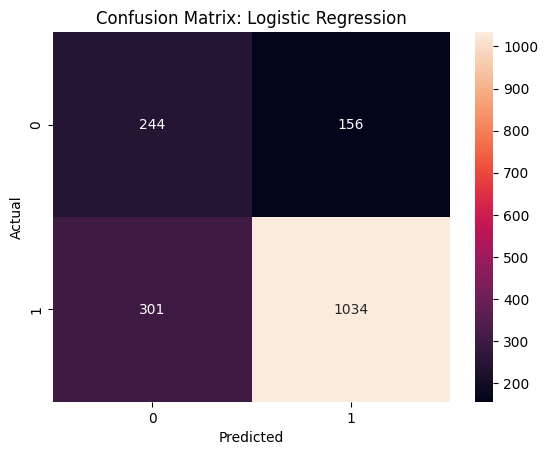

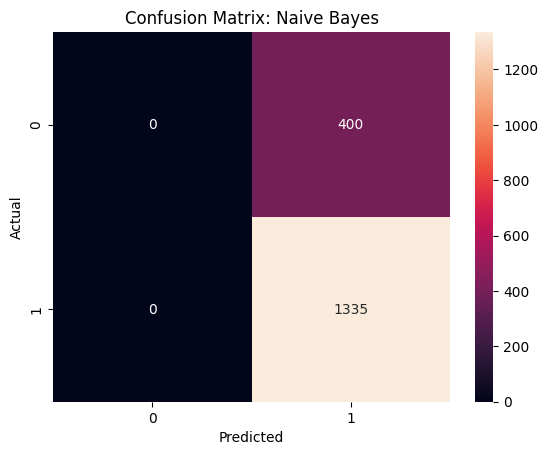

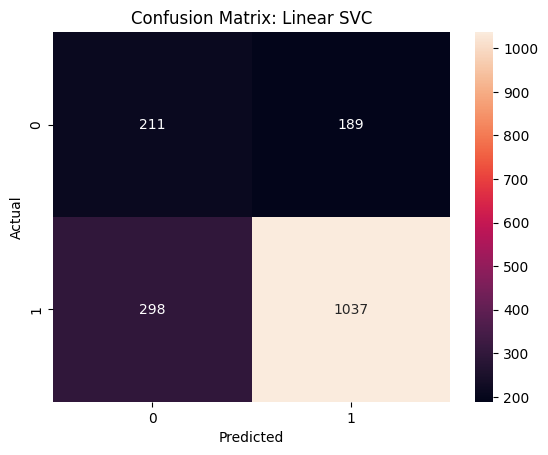

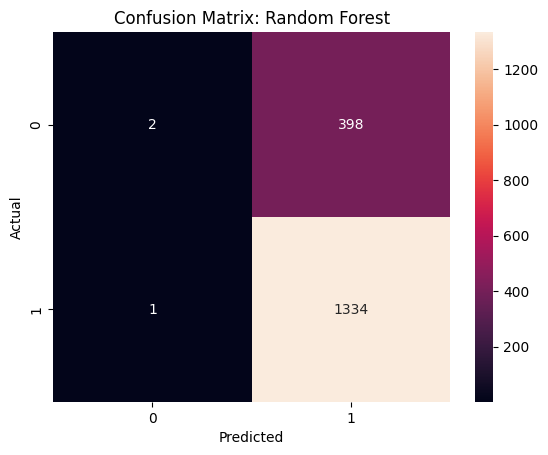

In [73]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

for name, clf in models.items():
    y_pred = clf.predict(X_test)
    plot_cm(y_test, y_pred, f"Confusion Matrix: {name}")

In [74]:
# Export preprocessing data
df[['processed', 'IE']].to_csv("../data/mbti_processed.csv", index=False)

In [75]:
# Save Logistic Regression model 
import pickle
with open("../model/lr_model.pkl", "wb") as f:
    pickle.dump(lr, f)

In [76]:
# Save vectorizer
with open("../model/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)